# Variational Inference for Neural Networks: example of a cubic function.

The network architecture is fixed (benchmark) to one hidden layer with 100 units (total of 301 weights). In this example, the prior is assumed known as standard gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import (
    Regressor, BayesByBackprop, alphaBB, ModelAveragingLOO, ModelAveragingLOOalphaBB, ModelAveragingInfoCriteria)

### Some plotting functions

In [2]:
fontsize = 15
ylim = (-2, 2); xlim = (-1., 1.)
set_axis_limits = lambda x: (x.set_ylim(ylim) and x.set_xlim(xlim))
set_labels = lambda x: (x.set_xlabel(r'input $X$', fontsize=fontsize) and x.set_ylabel(
    r'output $y$', fontsize=fontsize))
set_yticks = lambda x: x.set_yticks([-2., -1., 0, 1., 2.])
set_xticks = lambda x: x.set_xticks([-1., -0.5, 0., 0.5, 1.])
set_stuff = lambda x: (set_labels(x) and set_axis_limits(x) and set_yticks(x) and set_xticks(x) 
                       and plt.xticks(fontsize=13) and plt.yticks(fontsize=13))
kwargs_data = {'color': 'blue', 'linestyle': 'none', 'marker': 'x', 'markersize': 9, 'label': 'training data'}
colors_layers = ['green', 'blue', 'red', 'orange']
markers_layers = ['o', '+', 'x', 'd', 's', '+']
# look at uncertainty in terms of std. dev. or 95% interval?
# stat_to_plot = 'std'   # 'std' or 'perc'

def plot_loss(loss_history):
    n_epochs = len(loss_history)
    fig, ax = plt.subplots(figsize=(10, 2.5), ncols=2)
    ax[0].plot(np.arange(1, n_epochs+1), loss_history)
    ax[0].set_xlabel('epochs 1 to last'); ax[0].set_ylabel('loss')
    ax[1].plot(np.arange(n_epochs//2+1, n_epochs+1), loss_history[n_epochs//2:])
    ax[1].set_xlabel('epochs {} to last'.format(n_epochs//2)); ax[1].set_ylabel('loss')
    return fig, ax

def plot_convergence_VI(weights_mean, weights_std, weights_to_track):
    fig, ax = plt.subplots(figsize=(13,3.5), ncols=2)
    for l, (means, stds) in enumerate(zip(weights_mean[:-1], weights_std[:-1])):
        for j, (w_mean, w_std) in enumerate(zip(means.T, stds.T)):
            alpha = 0.15+j*0.8/weights_to_track[l]
            ax[0].plot(w_mean, color=colors_layers[l], alpha=alpha)
            ax[1].plot(w_std, color=colors_layers[l], alpha=alpha)
    ax[0].set_xlabel('epochs'); ax[0].set_ylabel(r'$\mu$'); 
    ax[0].set_title(r'Convergence of means $\mu_{i}$')
    ax[1].set_xlabel('epochs'); ax[1].set_ylabel(r'$\sigma$'); 
    ax[1].set_title(r'Convergence of std. devs. $\sigma_{i}$')
    return fig, ax

def plot_VI_mask(VI_mean, VI_std, fig=None, ax=None):
    from scipy.stats import norm
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 3.5), ncols=len(VI_mean))
    print('Av. std. dev. of weights = {}, {}, {}, {}'.format(
        np.mean(VI_std[0]), np.mean(VI_std[1]), np.mean(VI_std[2]), np.mean(VI_std[3])))
    for i, (mu, sig) in enumerate(zip(VI_mean, VI_std)):
        for m, s in zip(mu.reshape((-1,)), sig.reshape((-1,))):
            d = norm(loc=m, scale=s)
            md, vd = d.stats(moments='mv')
            xd = np.linspace(md - 3.*np.sqrt(vd), md+3.*np.sqrt(vd), 200)
            ax[i].plot(xd, d.pdf(xd))
    ax[0].set_title(r'$W^{[0]}$', fontsize=20); ax[0].set_xlim([-2.5, 2.5])
    ax[1].set_title(r'$b^{[0]}$', fontsize=20); ax[1].set_xlim([-2.5, 0])
    ax[2].set_title(r'$W^{[1]}$', fontsize=20); ax[2].set_xlim([-3., 3.])
    ax[3].set_title(r'$b^{[1]}$', fontsize=20); ax[3].set_xlim([-0.05, 0.05])
    for i in range(4):
        ax[i].set_xlabel(r'$\omega$', fontsize=16)
        ax[i].set_ylabel(r'$q_{\theta}(\omega)$', fontsize=16)
    return fig, ax

In [3]:
def plot_results_vi(reg, ns=10000, stat_to_plot='perc'):
    plot_loss(reg.loss_history)
    plt.show()
    plot_convergence_VI(reg.variational_mu_history, reg.variational_sigma_history, reg.weights_to_track)
    plt.show()

    VI_mean, VI_std = reg.return_marginals()
    fig, ax = plot_VI_mask(VI_mean=VI_mean, VI_std=VI_std)
    fig.tight_layout()
    plt.show(fig)

    fig, ax = plt.subplots(figsize=(6, 4.))
    if stat_to_plot == 'perc':
        y_mean, y_uq, y_MC = reg.predict_uq(
            X=x_plot, ns=ns, return_std=False, return_percentiles=(2.5, 97.5), return_MC=2, 
            aleatoric_in_std_perc=True, aleatoric_in_MC=False)
    elif stat_to_plot == 'std':
        y_mean, y_uq, y_MC = reg.predict_uq(
            X=x_plot, ns=ns, return_std=True, return_percentiles=(), return_MC=2, 
            aleatoric_in_std_perc=True, aleatoric_in_MC=False)
    plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
    #plot_mean_MC(x_plot, y_MC=y_MC, ax=ax, color_MC='red', label_MC='one posterior draw')
    ax.plot(xn, yn, **kwargs_data)
    ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.17), ncol=2, fancybox=True, shadow=True,
             fontsize=12)
    set_stuff(ax)
    fig.tight_layout()
    plt.show()
    return None

### Set the problem (data) and the network 

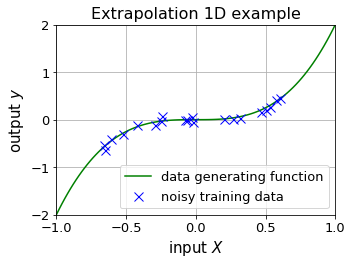

In [4]:
var_n = 0.05 ** 2
f = lambda x, noisy: 2 * x ** 3 + noisy*np.sqrt(var_n)*np.random.normal(size=x.shape)
n_data = 20
xn = np.array([-0.02519606, -0.29152739, -0.60474655, 0.31944225, -0.08100553, -0.24830156, 0.57461577, 
               0.50232181, 0.60433894, -0.02046175, 0.53479088, -0.65367602, -0.06110107, 0.46652892, 
               -0.66163461, 0.26793157, 0.20481661, -0.24144274, -0.42398829, -0.52080597]).reshape((-1, 1))
yn = np.array([0.04928457864952569, -0.11915410490457669, -0.405097551770553, 0.029554098140267056, 
               -0.013086956159543405, -0.017770100521146612, 0.42280077037504055, 0.1944984572601308, 
               0.4534092801344878, -0.05744532400253988, 0.27416952296635494, -0.6450129511010473, 
               -0.00434618253501617, 0.16330603887330705, -0.5274704221475347, 0.02189741180766931, 
               0.012647796994763167, 0.08367359752673682, -0.10875986459325471, 
               -0.2964629150726794]).reshape((-1, 1))
x_plot = np.linspace(-1, 1, 100).reshape((-1,1))
y_plot = f(x_plot, False)

fig, ax = plt.subplots(figsize=(5, 3.5), ncols=1)
ax.plot(x_plot, y_plot, **{'color': 'green', 'linestyle': '-', 'label': 'data generating function'})
ax.plot(xn, yn, color='blue', linestyle='none', marker='x', markersize=9, label='noisy training data')
set_stuff(ax)
ax.grid(True)
ax.set_title('Extrapolation 1D example', fontsize=16)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, shadow=True, fontsize=14)
plt.legend(fontsize=13, loc='lower right')
#plt.savefig('cubic_true_f.pdf', bbox_inches='tight')
plt.show()

In [5]:
nn = {'input_dim': 1, 
      'output_dim': 1,
      'var_n': var_n,
      'hidden_units': (100,),
      'activation': tf.nn.relu,
      'prior_means': 0.,
      'prior_stds': 1.}
weights_to_track = [] # track 5 kernel weights in each uq layer, and no bias
[weights_to_track.extend([5, 0]) for j in range(len(nn['hidden_units']) + 1)]

training_dict = {'epochs': 5000, 'lr': 0.005, 'ns': 20}

# Part 1: BayesByBackprop vs. alpha BB vs. MCMC

7.335611820220947


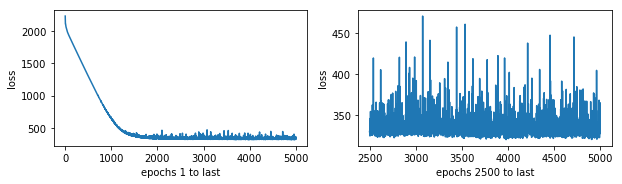

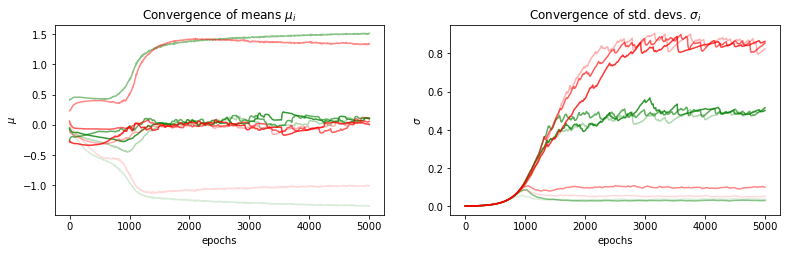

Av. std. dev. of weights = 0.49004340171813965, 0.30292460322380066, 0.8329498171806335, 0.011487954296171665


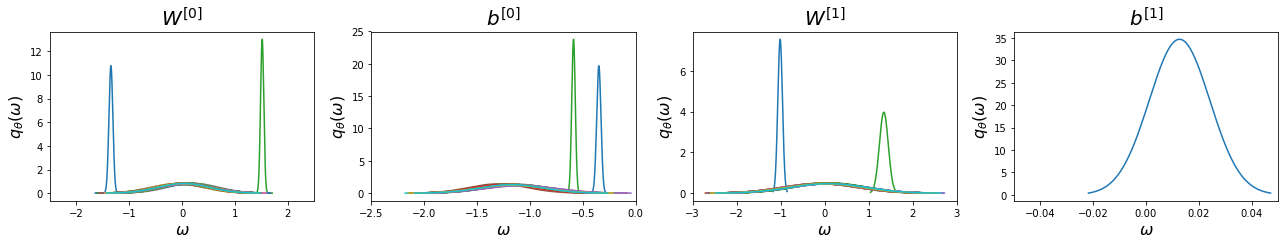

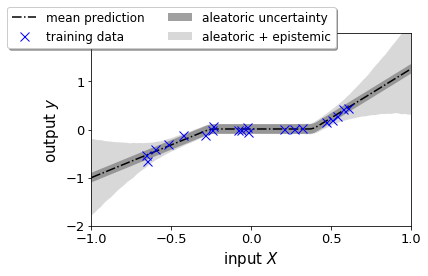

In [15]:
t0 = time.time()
reg_0 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, **nn)
reg_0.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_0)

9.79920220375061


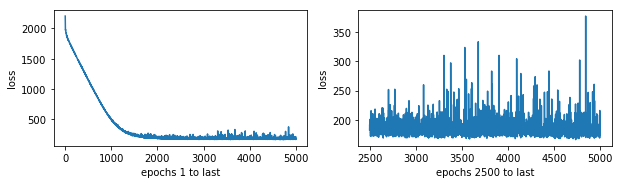

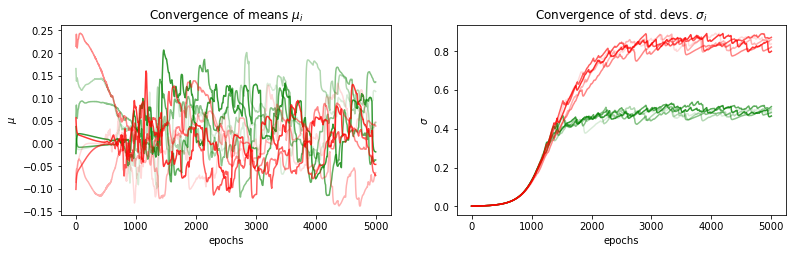

Av. std. dev. of weights = 0.4851151406764984, 0.30208730697631836, 0.8263824582099915, 0.010905771516263485


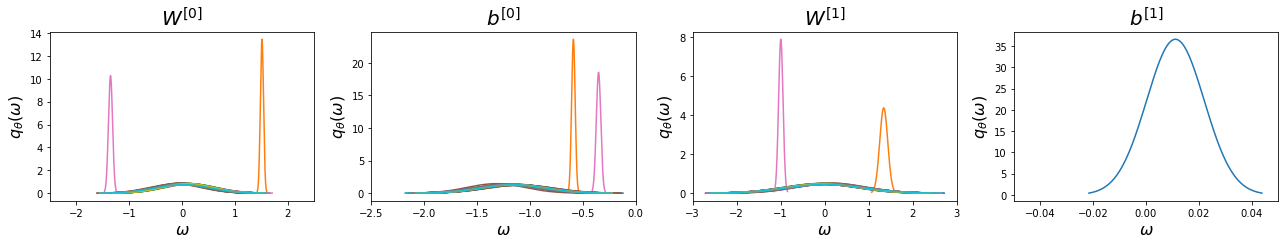

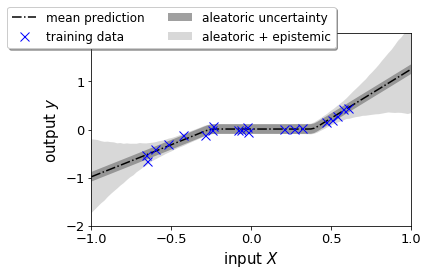

In [16]:
t0 = time.time()
reg_1 = alphaBB(alpha=0.0001, weights_to_track=weights_to_track, analytical_grads=True, **nn)
reg_1.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_1)

9.545135021209717


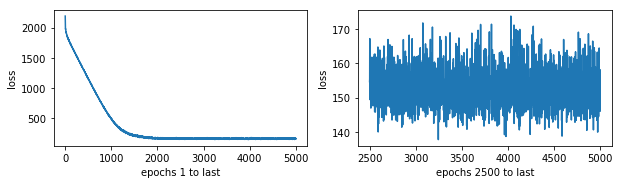

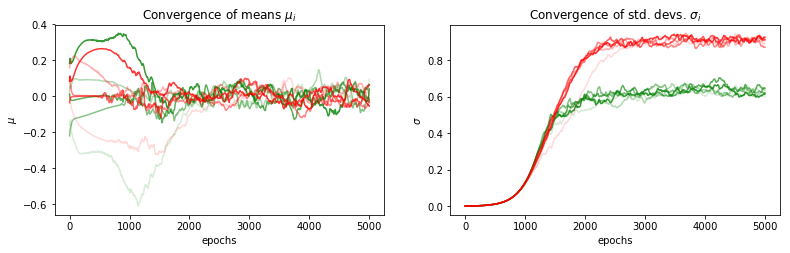

Av. std. dev. of weights = 0.6210774779319763, 0.3683028817176819, 0.8908095359802246, 0.014262687414884567


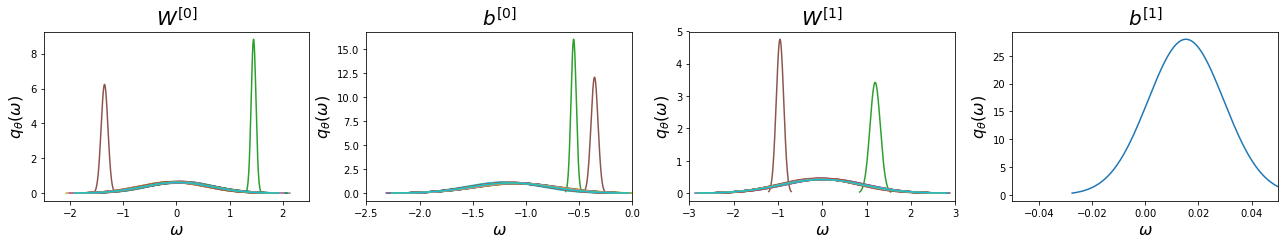

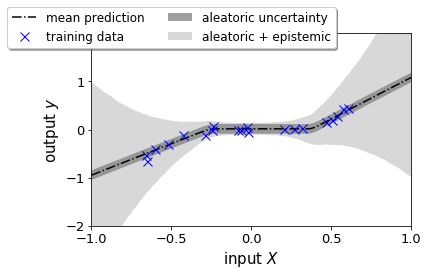

In [17]:
t0 = time.time()
reg_2 = alphaBB(alpha=0.2, weights_to_track=weights_to_track, analytical_grads=True, **nn)
reg_2.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_2)

In [19]:
t0 = time.time()
reg_fig_0 = BayesByBackprop(analytical_grads=True, **nn)
reg_fig_0.fit(X=xn, y=yn, **training_dict)
print('t for training = {}'.format(time.time()-t0))

t0 = time.time()
reg_fig_1 = alphaBB(alpha=0.1, **nn)
reg_fig_1.fit(X=xn, y=yn, **training_dict)
print('t for training = {}'.format(time.time()-t0))

t0 = time.time()
reg_fig_2 = alphaBB(alpha=0.2, **nn)
reg_fig_2.fit(X=xn, y=yn, **training_dict)
print('t for training = {}'.format(time.time()-t0))

regs_figure = [reg_fig_0, reg_fig_1, reg_fig_2]

t for training = 6.1742119789123535
t for training = 9.56006908416748
t for training = 10.879861116409302


Av. std. dev. of weights = 0.48896458745002747, 0.30389267206192017, 0.8305607438087463, 0.01096610352396965


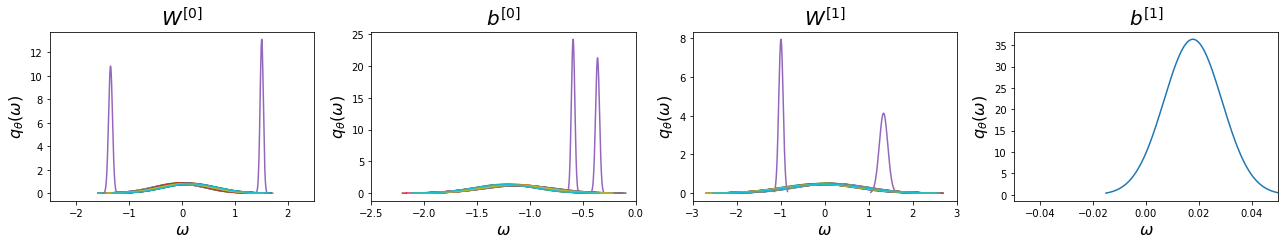

In [21]:
VI_mean, VI_std = reg_fig_0.return_marginals()
fig, ax = plot_VI_mask(VI_mean=VI_mean, VI_std=VI_std)
fig.tight_layout()
#plt.savefig('VI_posterior_cubic_cmame.pdf')
plt.show(fig)

Av. std. dev. of weights = 0.5741145610809326, 0.34698718786239624, 0.882399320602417, 0.012348301708698273


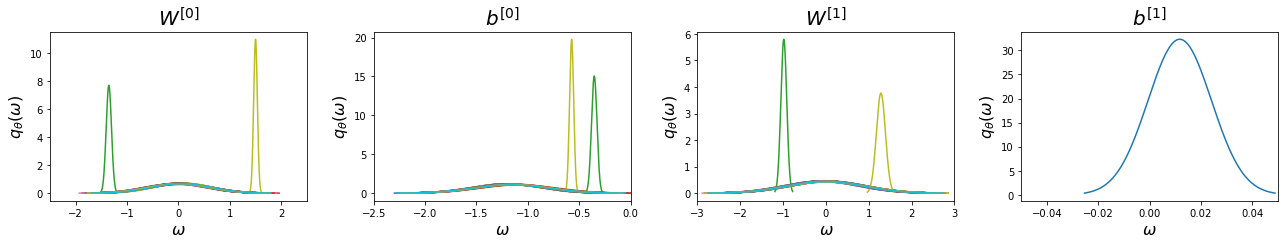

Av. std. dev. of weights = 0.6161484122276306, 0.36745503544807434, 0.889100193977356, 0.014020467177033424


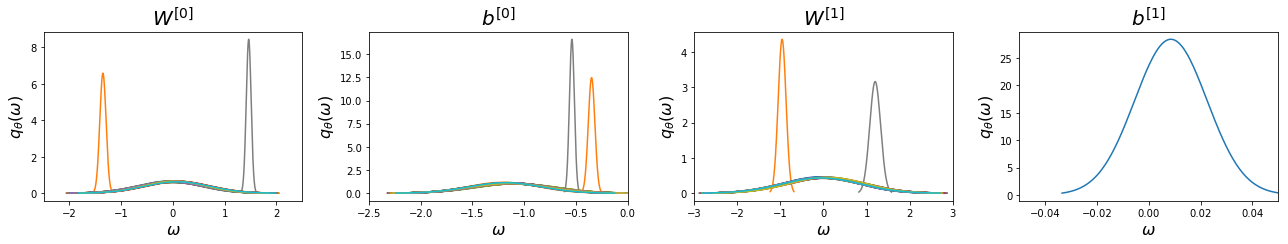

In [20]:
VI_mean, VI_std = reg_fig_1.return_marginals()
fig, ax = plot_VI_mask(VI_mean=VI_mean, VI_std=VI_std)
fig.tight_layout()
plt.show(fig)

VI_mean, VI_std = reg_fig_2.return_marginals()
fig, ax = plot_VI_mask(VI_mean=VI_mean, VI_std=VI_std)
fig.tight_layout()
plt.show(fig)

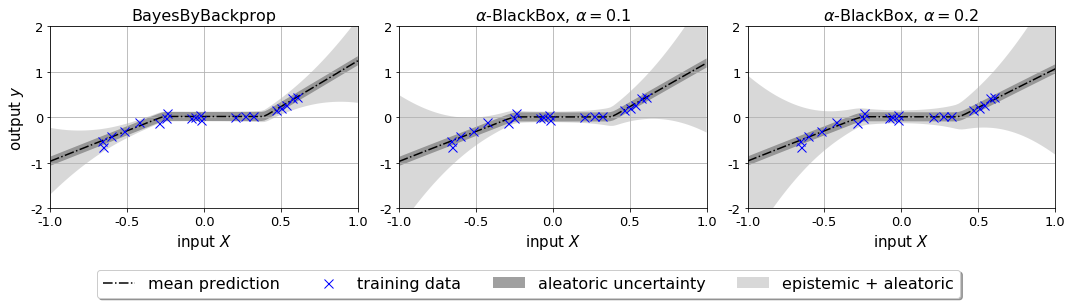

In [20]:
# The others
stat_to_plot = 'std'   # 'std' or 'perc'
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})

fig, ax = plt.subplots(ncols=3, figsize=(15, 3.7))
# MCMC
for i in range(3):
    dict_predict['ns']=10000
    if i == 0:
        reg = regs_figure[0]
        title = 'BayesByBackprop'
    elif i == 1:
        reg = regs_figure[1]
        title = r'$\alpha$-BlackBox, $\alpha=0.1$'
    elif i == 2:
        reg = regs_figure[2]
        title = r'$\alpha$-BlackBox, $\alpha=0.2$'
    y_mean, y_uq = reg.predict_uq(X=x_plot, **dict_predict)
    plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
    ax[i].plot(xn, yn, **kwargs_data)
    set_stuff(ax[i])
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_yticklabels([-2, -1, 0, 1, 2], fontsize=13)
    ax[i].set_xticklabels([-1.0, -0.5, 0., 0.5, 1.0], fontsize=13)
    ax[i].grid(True)
    ax[i].set_title(title, fontsize=16)
fig.legend(
    (ax[0].lines[0], ax[0].lines[1], ax[0].patches[0], ax[0].patches[1]),
    ('mean prediction', 'training data', 'aleatoric uncertainty', 'epistemic + aleatoric'),
    ncol=4, fancybox=True, shadow=True, fontsize=16,
    bbox_to_anchor=(0.9, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
#plt.savefig('cubic_3algos_cmame.pdf', bbox_inches='tight')
plt.show()

Time for training = 193.27667021751404
Acc rate = 68.06857142857143


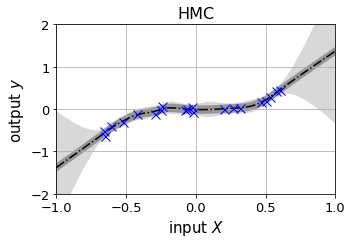

Diagnostics for parameters
av ESS = 74.0008544921875
av Rhat = 1.1284942626953125
Diagnostics for outputs
ESS
[ 511.67785827 1137.03204293 3810.21325821  769.59380169  405.34652469]
Rhat
[1.00827358 1.00164832 1.00084687 1.00277611 1.00500544]
301
140000
7000


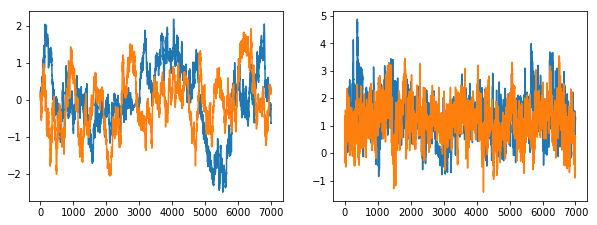

100
100
100
1


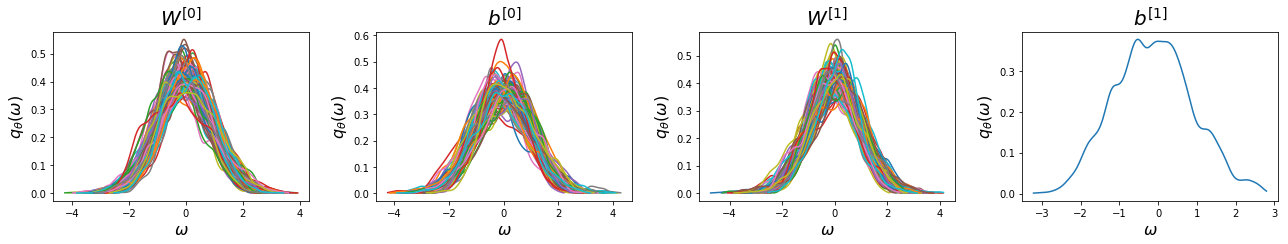

In [15]:
# MCMC alone
stat_to_plot = 'std'   # 'std' or 'perc'
fig, ax = plt.subplots(figsize=(5, 3.5))
dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
if stat_to_plot == 'std':
    dict_predict.update({'return_std': True, 'return_percentiles': ()})
# MCMC
import pickle
with open('MCMC_runs/hmc_cubic_20210516.pkl', 'rb') as f:
    mcmc_dict = pickle.load(f)
print('Time for training = {}'.format(mcmc_dict['time_training']))
print('Acc rate = {}'.format(mcmc_dict['acceptance_rate']))
reg = Regressor(**nn)
y_mean, y_uq = reg.predict_uq_from_samples(
    X=x_plot, network_weights=mcmc_dict['network_weights'], **dict_predict)
plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
ax.plot(xn, yn, **kwargs_data)
set_stuff(ax)
ax.grid(True)
ax.set_title('HMC', fontsize=16)
#fig.legend(
#    (ax.lines[0], ax.lines[1], ax.patches[0], ax.patches[1]),
#    ('mean prediction', 'training data', 'aleatoric uncertainty', 'epistemic + aleatoric'),
#    ncol=4, fancybox=True, shadow=True, fontsize=14,
#    bbox_to_anchor=(0.8, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
plt.savefig('cubic_hmc_cmame.pdf', bbox_inches='tight')
plt.show()

# Look at a couple of chains
print('Diagnostics for parameters')
print('av ESS = {}'.format(mcmc_dict['diagnostics']['ESS_params']))
print('av Rhat = {}'.format(mcmc_dict['diagnostics']['Rhat_params']))

print('Diagnostics for outputs')
print('ESS')
print(np.array(mcmc_dict['diagnostics']['ESS_outpt'])[:, 1])
print('Rhat')
print(np.array(mcmc_dict['diagnostics']['Rhat_outpt'])[:, 1])
    
num_iterations = mcmc_dict['network_weights'][0].shape[0] // mcmc_dict['nchains']
print(reg.n_weights)
print(num_iterations * mcmc_dict['n_jump'] + mcmc_dict['n_burnin'])
print(num_iterations)
fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
for j in range(2):
    weights_j = [w[j * num_iterations:(j+1) * num_iterations] for w in mcmc_dict['network_weights']]
    ymean, yMC = reg.predict_uq_from_samples(
        X=np.array([[0.95, ], ]), network_weights=weights_j, return_MC=num_iterations, 
        return_std=False, return_percentiles=())
    ax[0].plot(weights_j[0][:, 0, 0])
    ax[1].plot(yMC[:, 0, 0])
plt.show()

fig, ax = plt.subplots(figsize=(18, 3.5), ncols=len(mcmc_dict['network_weights']))
from scipy.stats import gaussian_kde
for i, w in enumerate(mcmc_dict['network_weights']):
    print(len(w.reshape((w.shape[0], -1)).T))
    for w_ in w.reshape((w.shape[0], -1)).T:
        kernel = gaussian_kde(w_)
        xd = np.linspace(min(w_), max(w_), 200)
        ax[i].plot(xd, kernel(xd))
ax[0].set_title(r'$W^{[0]}$', fontsize=20); #ax[0].set_xlim([-3., 3.])
ax[1].set_title(r'$b^{[0]}$', fontsize=20); #ax[1].set_xlim([-3., 3.])
ax[2].set_title(r'$W^{[1]}$', fontsize=20); #ax[2].set_xlim([-3., 3.])
ax[3].set_title(r'$b^{[1]}$', fontsize=20); #ax[3].set_xlim([-3., 3.])
for i in range(4):
    ax[i].set_xlabel(r'$\omega$', fontsize=16)
    ax[i].set_ylabel(r'$q_{\theta}(\omega)$', fontsize=16)
fig.tight_layout()
plt.savefig('cubic_hmc_posteriors_cmame.pdf', bbox_inches='tight')
plt.show()

# Part 2: Look at alpha Black-Box and model comparisons

First show principle: train one model on two LOO sets.

In [23]:
ind_i = [2, 19, 11]
xn_train = np.array([xn[j] for j in range(xn.shape[0]) if j not in ind_i])
yn_train = np.array([yn[j] for j in range(xn.shape[0]) if j not in ind_i])
xn_leave = np.array([xn[j] for j in range(xn.shape[0]) if j in ind_i])
yn_leave = np.array([yn[j] for j in range(xn.shape[0]) if j in ind_i])

In [24]:
reg = alphaBB(alpha=0.1, random_seed=4567, **nn)
reg.fit(X=xn, y=yn, **training_dict)

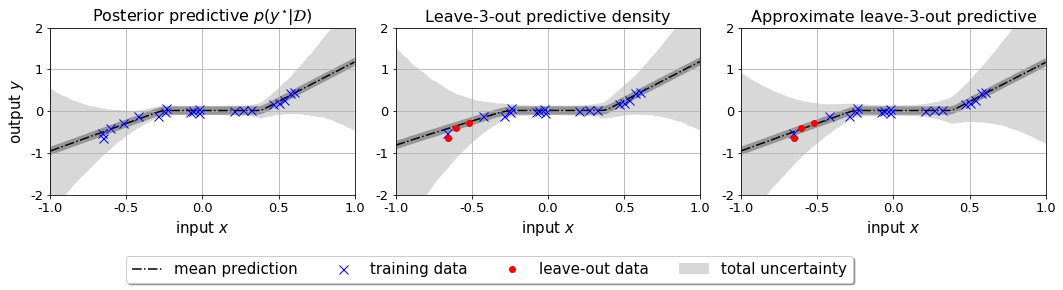

In [25]:
fig, ax = plt.subplots(figsize=(15, 3.5), ncols=3)
for i in [0, 2, 1]:
    if i == 0:
        y_mean, y_perc = reg.predict_uq(
            X=x_plot, ns=10000, return_std=False, return_percentiles=(2.5, 97.5), return_MC=0, 
            aleatoric_in_std_perc=True)
        title = r'Posterior predictive $p(y^{\star} \vert \mathcal{D})$'
    elif i == 2:
        leave_factors = ind_i
        y_mean, y_perc = reg.predict_uq_from_lso(
            X=x_plot, leave_factors=leave_factors, ns=10000, return_std=False, return_percentiles=(2.5, 97.5),  
            aleatoric_in_std_perc=True)
        title = r'Approximate leave-3-out predictive'
    elif i == 1:
        reg = alphaBB(alpha=0.1, random_seed=4567, **nn)
        reg.fit(X=xn_train, y=yn_train, **training_dict)
        y_mean, y_perc = reg.predict_uq(
            X=x_plot, ns=10000, return_std=False, return_percentiles=(2.5, 97.5), return_MC=0, 
            aleatoric_in_std_perc=True)
        title = r'Leave-3-out predictive density'
    plot_mean_percentiles(x_plot, y_perc=y_perc, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
    set_stuff(ax[i])
    if i == 0:
        ax[i].plot(xn, yn, **kwargs_data)
        ax[i].set_ylabel(r'output $y$', fontsize=15)
        ax[i].set_xlabel(r'input $x$', fontsize=15)
    else:
        ax[i].plot(xn_train, yn_train, **kwargs_data)
        ax[i].plot(xn_leave, yn_leave, color='red', marker='o', linestyle='none', label='leave-out data')
        ax[i].set_ylabel('')
        ax[i].set_xlabel(r'input $x$', fontsize=15)
    ax[i].set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax[i].set_xticklabels([-1., -0.5, 0., 0.5, 1.], fontsize=13)
    ax[i].set_yticklabels([-2, -1, 0, 1, 2], fontsize=13)
    ax[i].grid(True, which='both')
    ax[i].set_title(title, fontsize=16)
fig.legend(
    (ax[1].lines[0], ax[1].lines[1], ax[1].lines[2], ax[1].patches[1]),
    ('mean prediction', 'training data', 'leave-out data', 'total uncertainty'),
    ncol=4, fancybox=True, shadow=True, fontsize=15,
    bbox_to_anchor=(0.8, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
fig.savefig('cubic_L3O_cmame.pdf', xbbox_inches = "tight")
plt.show()

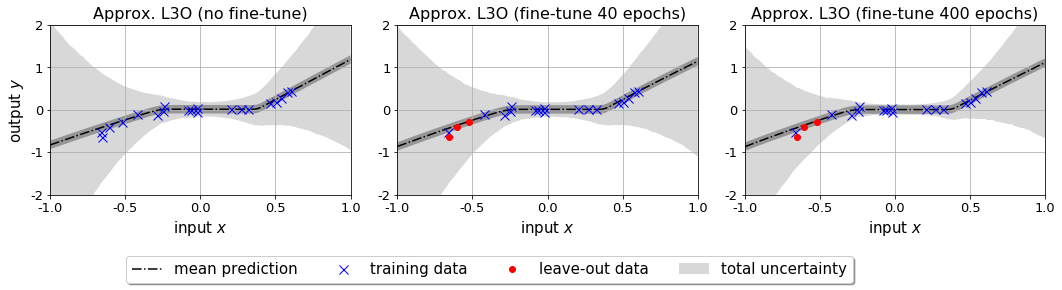

In [26]:
fig, ax = plt.subplots(figsize=(15, 3.5), ncols=3)
leave_factors = ind_i
for i in [0, 1, 2]:
    if i == 0:
        leave_factors = ind_i
        y_mean, y_perc = reg.predict_uq_from_lso(
            X=x_plot, leave_factors=leave_factors, ns=10000, return_std=False, return_percentiles=(2.5, 97.5),  
            aleatoric_in_std_perc=True)
        title = r'Approx. L3O (no fine-tune)'
    elif i == 1:
        leave_factors = ind_i
        y_mean, y_perc = reg.predict_uq_from_lso(
            X=x_plot, leave_factors=leave_factors, ns=10000, return_std=False, return_percentiles=(2.5, 97.5),  
            aleatoric_in_std_perc=True, ns_refit=10, lr_refit=0.005, epochs_refit=40)
        title = r'Approx. L3O (fine-tune 40 epochs)'
    elif i == 2:
        leave_factors = ind_i
        y_mean, y_perc = reg.predict_uq_from_lso(
            X=x_plot, leave_factors=leave_factors, ns=10000, return_std=False, return_percentiles=(2.5, 97.5),  
            aleatoric_in_std_perc=True, ns_refit=10, lr_refit=0.005, epochs_refit=400)
        title = r'Approx. L3O (fine-tune 400 epochs)'
    plot_mean_percentiles(x_plot, y_perc=y_perc, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
    set_stuff(ax[i])
    if i == 0:
        ax[i].plot(xn, yn, **kwargs_data)
        ax[i].set_ylabel(r'output $y$', fontsize=15)
        ax[i].set_xlabel(r'input $x$', fontsize=15)
    else:
        ax[i].plot(xn_train, yn_train, **kwargs_data)
        ax[i].plot(xn_leave, yn_leave, color='red', marker='o', linestyle='none', label='leave-out data')
        ax[i].set_ylabel('')
        ax[i].set_xlabel(r'input $x$', fontsize=15)
    ax[i].set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax[i].set_xticklabels([-1., -0.5, 0., 0.5, 1.], fontsize=13)
    ax[i].set_yticklabels([-2, -1, 0, 1, 2], fontsize=13)
    ax[i].grid(True, which='both')
    ax[i].set_title(title, fontsize=16)
fig.legend(
    (ax[1].lines[0], ax[1].lines[1], ax[1].lines[2], ax[1].patches[1]),
    ('mean prediction', 'training data', 'leave-out data', 'total uncertainty'),
    ncol=4, fancybox=True, shadow=True, fontsize=15,
    bbox_to_anchor=(0.8, 0), bbox_transform=plt.gcf().transFigure)
fig.tight_layout()
fig.savefig('cubic_L3O_cmame_2.pdf', xbbox_inches = "tight")
plt.show()

## Part 3: do average over models

In [6]:
def plot_regressors(regressors, stat_to_plot, titles, figsize=(20, 3.), ns=10000):
    dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                    'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
    if stat_to_plot == 'std':
        dict_predict.update({'return_std': True, 'return_percentiles': ()})
    
    fig, ax = plt.subplots(ncols=len(regressors), figsize=figsize)
    for i, (reg_props, title) in enumerate(zip(regressors, titles)):
        reg = set_properties_vi(*reg_props)
        y_mean, y_uq = reg.predict_uq(X=x_plot, ns=ns, **dict_predict)
        plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax[i], y_mean=y_mean, var_aleatoric=var_n)
        ax[i].plot(xn, yn, **kwargs_data)
        set_stuff(ax[i])
        if i != 0:
            ax[i].set_ylabel('')
        if titles is not None:
            ax[i].set_title(title, fontsize=16)
        ax[i].grid(True)
    fig.tight_layout()
    return fig

def plot_regressors_v2(regressors, stat_to_plot, titles, figsize=(20, 7.), ns=10000):
    dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                    'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
    if stat_to_plot == 'std':
        dict_predict.update({'return_std': True, 'return_percentiles': ()})
        
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(2, 6)
    list_gs = [gs[0, :2], gs[0, 2:4], gs[0, 4:], gs[1, 1:3], gs[1, 3:5]]
    for i, (reg_props, title, g) in enumerate(zip(regressors, titles, list_gs)):
        ax = fig.add_subplot(g)
        reg = set_properties_vi(*reg_props)
        y_mean, y_uq = reg.predict_uq(X=x_plot, ns=ns, **dict_predict)
        plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
        ax.plot(xn, yn, **kwargs_data)
        set_stuff(ax)
        ax.set_xticklabels([-1., -0.5, 0., 0.5, 1.], fontsize=13)
        ax.set_yticklabels([-2, -1, 0, 1, 2], fontsize=13)
        if titles is not None:
            ax.set_title(title, fontsize=16)
        ax.grid(True)
        if i == 0:
            fig.legend(
                (ax.lines[0], ax.lines[1], ax.patches[0], ax.patches[1]),
                ('mean prediction', 'training data', 'aleatoric uncertainty', 'total uncertainty'),
                ncol=4, fancybox=True, shadow=True, fontsize=15,
                bbox_to_anchor=(0.85, 0), bbox_transform=plt.gcf().transFigure)
    fig.tight_layout()
    return fig
    
def plot_av_regressor(model_aving, stat_to_plot, figsize=(5, 3.5), ns=10000):
    dict_predict = {'return_std': False, 'return_percentiles': (2.5, 97.5), 'return_MC': 0, 
                    'aleatoric_in_std_perc': True, 'aleatoric_in_MC': False}
    if stat_to_plot == 'std':
        dict_predict.update({'return_std': True, 'return_percentiles': ()})
        
    fig, ax = plt.subplots(figsize=figsize)
    y_mean, y_uq = model_aving.predict_uq(X=x_plot, ns=ns, **dict_predict)
    plot_mean_uq(x=x_plot, y_uq=y_uq, type_uq=stat_to_plot, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
    ax.plot(xn, yn, **kwargs_data)
    #ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.17), ncol=2, fancybox=True, shadow=True)
    set_stuff(ax)
    ax.grid(True)
    fig.tight_layout()
    return fig

In [7]:
alpha_list = [0, 0.05, 0.1, 0.15, 0.2]
#random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)
#[6598, 1679, 5324, 2479, 5861]
random_seed_list = [5324, ] * len(alpha_list)
print(random_seed_list)

[5324, 5324, 5324, 5324, 5324]


In [8]:
t0 = time.time()
model_aving = ModelAveragingLOOalphaBB(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list, random_seed_list=random_seed_list, LOO=True)
print('Time for approx pseudo-BMA = {}'.format(time.time()-t0))

print('elpd:')
print(model_aving.elpd)
print('Weights:')
print(model_aving.weights_elpd)
print(model_aving.weights_modified_elpd)
print(model_aving.weights_elpd_bb)

Adding model with alpha=0.0001

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Adding model with alpha=0.05
Adding model with alpha=0.1
Adding model with alpha=0.15
Adding model with alpha=0.2
Time for approx pseudo-BMA = 38.078510999679565
elpd:
[29.94212, 28.465923, 26.824411, 25.394394, 23.778328]
Weights:
[0.7779322  0.17776155 0.0344301  0.00823929 0.00163697]
[0.77062629 0.17796754 0.040329   0.00931176 0.00176542]
[0.70133092 0.16239837 0.09485433 0.03415337 0.00726301]


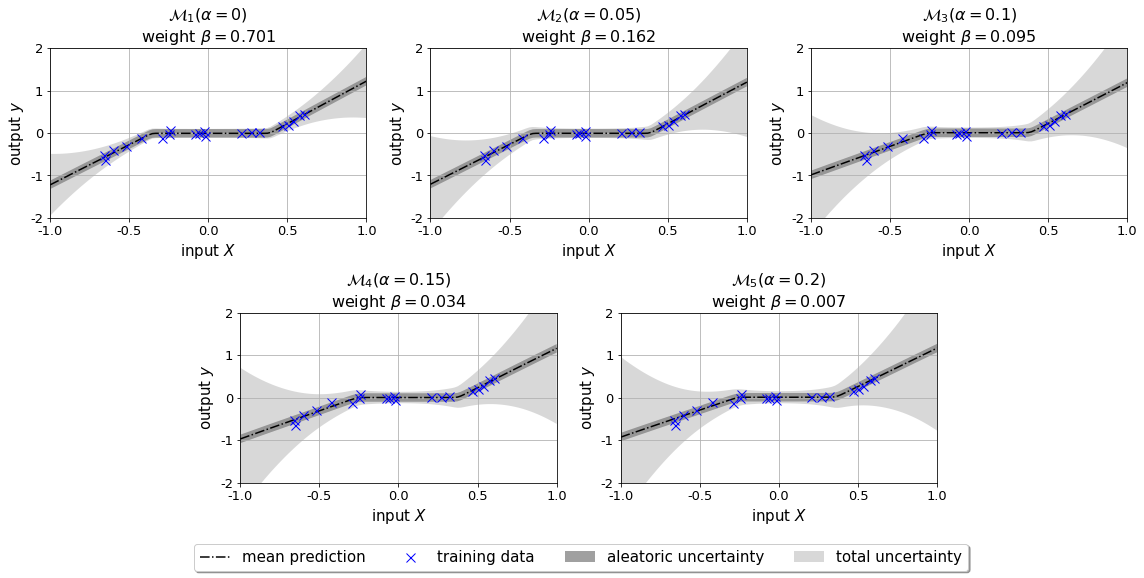

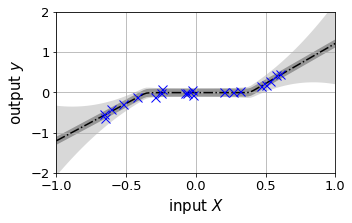

In [9]:
stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list, getattr(model_aving, weights_attribute)))]
fig0 = plot_regressors_v2(regressors=model_aving.regressors, stat_to_plot=stat_to_plot, titles=titles, 
                       figsize=(16, 7.5), ns=10000)
#fig0.savefig('cubic_LOOalphaBB_all_cmame.pdf', xbbox_inches = "tight")
fig0.show()

fig1 = plot_av_regressor(model_aving, stat_to_plot=stat_to_plot, figsize=(5, 3.2), ns=50000)
#fig1.savefig('cubic_LOOalphaBB_average_cmame.pdf', xbbox_inches = "tight")
fig1.show()

In [31]:
t0 = time.time()
model_aving_refit = ModelAveragingLOOalphaBB(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict, n_bootstrap=100,
    alpha_list=alpha_list, random_seed_list=random_seed_list, lr_refit=0.005, ns_refit=20, epochs_refit=40)
print('Time for approx pseudo-BMA = {}'.format(time.time()-t0))

print('elpd:')
print(model_aving_refit.elpd)
print('Weights:')
print(model_aving_refit.weights_elpd)
print(model_aving_refit.weights_modified_elpd)
print(model_aving_refit.weights_elpd_bb)

Adding model with alpha=0.0001
Adding model with alpha=0.05
Adding model with alpha=0.1
Adding model with alpha=0.15
Adding model with alpha=0.2
Time for approx pseudo-BMA = 218.7254762649536
elpd:
[26.620663, 25.59942, 23.210884, 22.086899, 20.843552]
Weights:
[0.71071476 0.255962   0.02348807 0.0076332  0.00220155]
[0.69527964 0.26623574 0.02653074 0.00921252 0.00274136]
[0.66863576 0.23723046 0.06198474 0.02115563 0.01099341]


In [17]:
t0 = time.time()
model_aving_2 = ModelAveragingLOO(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict,
    alpha_list=alpha_list, random_seed_list=random_seed_list)
print('Time for approx pseudo-BMA = {}'.format(time.time()-t0))

print('elpd:')
print(model_aving_2.elpd)
print('Weights:')
print(model_aving_2.weights_elpd)
print(model_aving_2.weights_modified_elpd)
print(model_aving_2.weights_elpd_bb)

Adding model with alpha=0
Adding model with alpha=0.05
Adding model with alpha=0.1
Adding model with alpha=0.15
Adding model with alpha=0.2
Time for approx pseudo-BMA = 913.7064759731293
elpd:
[23.348372156423636, 22.790144617361136, 22.130181963247367, 21.469826395315238, 19.916573221487113]
Weights:
[0.48706163 0.27870758 0.14405576 0.07442894 0.01574608]
[0.43167651 0.27425188 0.17767683 0.09583832 0.02055646]
[0.47239578 0.25557552 0.13691022 0.09745808 0.03766039]


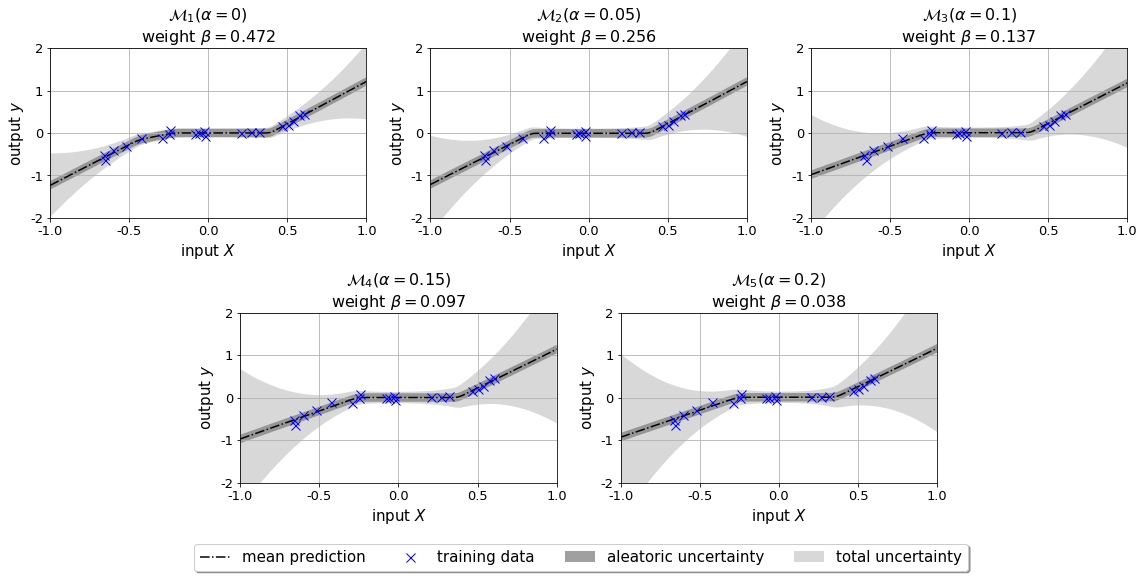

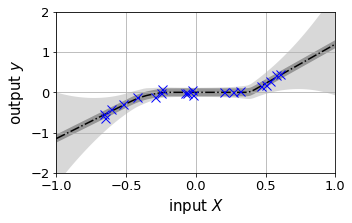

In [18]:
stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list, getattr(model_aving_2, weights_attribute)))]
fig0 = plot_regressors_v2(regressors=model_aving_2.regressors, stat_to_plot=stat_to_plot, titles=titles, 
                       figsize=(16, 7.5), ns=5000)
fig0.show()

fig1 = plot_av_regressor(model_aving_2, stat_to_plot=stat_to_plot, figsize=(5, 3.2), ns=5000)
fig1.show()

Weights based on other info criteria / direct evidence calculation

In [8]:
t0 = time.time()
model_aving_3 = ModelAveragingInfoCriteria(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict,
    alpha_list=alpha_list, random_seed_list=random_seed_list, scaling_kic=1.06 / np.sqrt(20))
print('Time for approx pseudo-BMA = {}'.format(time.time()-t0))

print('DIC')
print(model_aving_3.weights_dic)
print('WAIC')
print(model_aving_3.weights_waic)

print('KIC')
print(model_aving_3.weights_kic)
print('KIC smoothed')
print(model_aving_3.weights_kic_smoothed)
print('Evidence')
print(model_aving_3.weights_evidence)

print(model_aving_3.kic)
print(model_aving_3.log_evidence)

Adding model with alpha=0

Instructions for updating:
Use `tf.cast` instead.
Adding model with alpha=0.05
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Adding model with alpha=0.1
Adding model with alpha=0.15
Adding model with alpha=0.2
Time for approx pseudo-BMA = 39.33276581764221
DIC
[1.00000000e+000 2.49490826e-025 3.42241229e-062 5.21902536e-095
 8.29351416e-148]
WAIC
[1. 0. 0. 0. 0.]
KIC
[4.59255726e-26 5.53766076e-13 9.84148355e-08 1.25040580e-03
 9.98749496e-01]
KIC smoothed
[8.03834007e-07 1.01328437e-03 1.77844393e-02 1.67024869e-01
 8.14176603e-01]
Evidence
[4.59250481e-26 5.53757374e-13 9.84138053e-08 1.25038318e-03
 9.98749518e-01]
[538.3012145815268, 478.0597318468466, 453.8838123140707, 434.98423803428557, 421.61816633323576]
[-269.15061950683594, -239.02988243103027, -226.9419174194336, -217.49213790893555, -210.80908393859863]


Make sure all weighting schemes reject runs that underfit too much

In [9]:
alpha_list_bis = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
#random_seed_list = generate_seeds(nseeds=len(alpha_list), nfigures=4)
#[6598, 1679, 5324, 2479, 5861]
random_seed_list_bis = [5324, ] * len(alpha_list_bis)
print(random_seed_list_bis)

[5324, 5324, 5324, 5324, 5324, 5324]


In [10]:
model_aving_bis = ModelAveragingLOOalphaBB(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict,
    alpha_list=alpha_list_bis, random_seed_list=random_seed_list_bis)

print(model_aving_bis.weights_elpd)
print(model_aving_bis.weights_modified_elpd)
print(model_aving_bis.weights_elpd_bb)

Adding model with alpha=0.0001
Adding model with alpha=0.1
Adding model with alpha=0.2
Adding model with alpha=0.3
Adding model with alpha=0.4
Adding model with alpha=0.5
[9.5368630e-01 4.4454169e-02 1.8265671e-03 3.2861593e-05 1.9855467e-07
 1.4800972e-10]
[9.45117489e-01 5.28763292e-02 1.97662615e-03 2.94010226e-05
 1.54054057e-07 9.10392459e-11]
[8.96765272e-01 9.69776221e-02 6.03497857e-03 2.18679905e-04
 3.44094449e-06 6.59582190e-09]


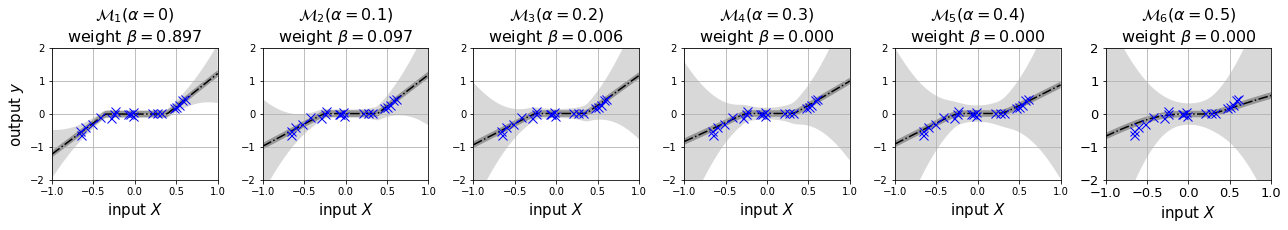

In [11]:
stat_to_plot = 'std'
weights_attribute = 'weights_elpd_bb'

titles = [r'$\mathcal{}_{}(\alpha={})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list_bis, getattr(model_aving_bis, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_bis.regressors, stat_to_plot=stat_to_plot, titles=titles, 
                       figsize=(18, 3.3), ns=10000)

fig0.show()

In [12]:
model_aving_bis2 = ModelAveragingInfoCriteria(
    nn_dict=nn, training_data=(xn, yn), training_dict=training_dict,
    alpha_list=alpha_list_bis, random_seed_list=random_seed_list_bis, scaling_kic=1.06/np.sqrt(20))

print('DIC')
print(model_aving_bis2.weights_dic)
print('WAIC')
print(model_aving_bis2.weights_waic)

print('KIC')
print(model_aving_bis2.weights_kic)
print('KIC smoothed')
print(model_aving_bis2.weights_kic_smoothed)
print('Evidence')
print(model_aving_bis2.weights_evidence)

Adding model with alpha=0
Adding model with alpha=0.1
Adding model with alpha=0.2
Adding model with alpha=0.3
Adding model with alpha=0.4
Adding model with alpha=0.5
DIC
[1.00000000e+000 4.26875640e-060 5.07614765e-137 3.71194667e-265
 0.00000000e+000 0.00000000e+000]
WAIC
[1. 0. 0. 0. 0. 0.]
KIC
[5.42370465e-37 1.16225660e-18 1.17950022e-11 1.55261761e-06
 9.99998447e-01 1.07439321e-21]
KIC smoothed
[2.42787310e-09 5.37155200e-05 2.45911152e-03 4.01963741e-02
 9.57280541e-01 1.02550667e-05]
Evidence
[5.42360249e-37 1.16223582e-18 1.17949150e-11 1.55260613e-06
 9.99998447e-01 1.07439065e-21]


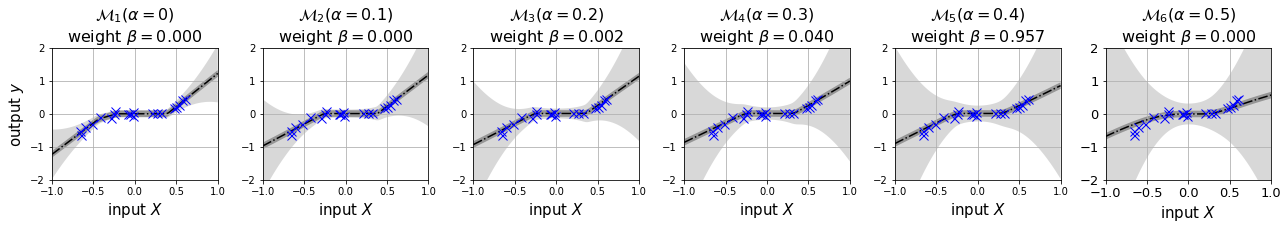

In [13]:
stat_to_plot = 'std'
weights_attribute = 'weights_kic_smoothed'

titles = [r'$\mathcal{}_{}(\alpha={})$'.format('{M}', i+1, alpha)+'\n'+r'weight $\beta={:.3f}$'.format(w_) 
          for i, (alpha, w_) in enumerate(zip(alpha_list_bis, getattr(model_aving_bis2, weights_attribute)))]
fig0 = plot_regressors(regressors=model_aving_bis2.regressors, stat_to_plot=stat_to_plot, titles=titles, 
                       figsize=(18, 3.3), ns=10000)

fig0.show()